In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time

# Set random seed for reproducibility
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

# Check GPU memory if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

Using device: mps


## Load Dataset

In [2]:
class PetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with the dataset.
            split (string): 'train', 'val' or 'test' split.
            transform (callable, optional): Transform to be applied on the input image and mask.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        # Set paths for images and masks
        self.image_dir = os.path.join(root_dir, split, 'color')
        self.mask_dir = os.path.join(root_dir, split, 'label')
        
        # Get all image file names
        if os.path.exists(self.image_dir):
            self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                      if os.path.isfile(os.path.join(self.image_dir, f))])
        else:
            print(f"Warning: Image directory {self.image_dir} does not exist")
            self.image_files = []
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Get corresponding mask file
        mask_name = img_name.replace('.jpg', '.png')
        if not os.path.exists(os.path.join(self.mask_dir, mask_name)):
            # Try with other extensions if needed
            mask_name = img_name.split('.')[0] + '.png'
            
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        
        # Load and process mask
        mask = Image.open(mask_path).convert('RGB')
        mask_np = np.array(mask)
        
        # Convert RGB mask to class indices
        seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        
        # Background (black)
        black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[black_mask] = 0
        # Cat (red)
        red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[red_mask] = 1
        # Dog (green)
        green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
        seg_mask[green_mask] = 2
        # White border (ignore)
        white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
        seg_mask[white_mask] = 255  # Use 255 as ignore index
        
        # Create a PIL Image from the segmentation mask
        seg_mask_pil = Image.fromarray(seg_mask)
        
        # Apply joint transformations
        if self.transform:
            image_transformed, seg_mask_transformed = self.transform(image, seg_mask_pil)
            return image_transformed, seg_mask_transformed
        else:
            # Convert to tensor if no transform
            image = TF.resize(image, (224, 224))
            seg_mask_pil = TF.resize(seg_mask_pil, (224, 224), interpolation=TF.InterpolationMode.NEAREST)
            
            image_tensor = TF.to_tensor(image)
            seg_mask_tensor = torch.from_numpy(np.array(seg_mask_pil)).long()
            
            return image_tensor, seg_mask_tensor

In [3]:
# Set paths and create datasets
data_root = '../Dataset_augmented/'

# Create datasets - directly use train/val/test splits from the augmented dataset
train_dataset = PetDataset(data_root, 'train')
val_dataset = PetDataset(data_root, 'val')
test_dataset = PetDataset(data_root, 'test')

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print(f"Checking dataset contents...")
train_dir = os.path.join(data_root, 'train', 'color')
print(f"Train image count: {len(os.listdir(train_dir))}")
print(f"Checking first few images...")
for i, f in enumerate(os.listdir(train_dir)[:5]):
    path = os.path.join(train_dir, f)
    size = os.path.getsize(path) / (1024*1024)  # Size in MB
    print(f"  {f}: {size:.2f} MB")

# Create dataloaders
batch_size = 64
num_workers = 0 # Use more workers for GPU training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Training set size: 11776
Validation set size: 736
Test set size: 3710
Checking dataset contents...
Train image count: 11776
Checking first few images...
  Persian_188_aug1.jpg: 0.01 MB
  leonberger_143_aug2.jpg: 0.01 MB
  Sphynx_151_aug0.jpg: 0.01 MB
  Birman_100_aug0.jpg: 0.01 MB
  Abyssinian_142_aug0.jpg: 0.01 MB


## Define Autoencoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # Input: (3, 128, 128)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 16, 16)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 8, 8)
            
            nn.Conv2d(256, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (latent_dim, 4, 4)
        )
        
    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # Input: (latent_dim, 4, 4)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # (3, 128, 128)
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        return self.decoder(x)


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [5]:
def visualize_reconstructions(model, data_loader, device, run_path, epoch):
    model.eval()
    with torch.no_grad():
        # Get a batch of images
        images, _ = next(iter(data_loader))
        images = images.to(device)
        
        # Get reconstructions
        reconstructed = model(images)
        
        # Move tensors to CPU and convert to numpy arrays
        images = images.cpu().numpy()
        reconstructed = reconstructed.cpu().numpy()
        
        # Plot a few examples
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        
        for i in range(5):
            # Original images in top row
            axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images in bottom row
            axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{run_path}/reconstruction_epoch_{epoch+1}.png')
        plt.close()

In [6]:
def train_autoencoder(model, train_loader, val_loader, run_path, num_epochs=10):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = next(model.parameters()).device
    
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for images, _ in pbar:
                images = images.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, images)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Update statistics
                running_loss += loss.item() * images.size(0)
                pbar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)
                
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{run_path}/autoencoder.pth')
            print(f"Saved best autoencoder model with validation loss: {best_val_loss:.4f}")
            
        # Visualize some reconstructions
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            visualize_reconstructions(model, val_loader, device, run_path, epoch)

    return train_losses, val_losses, best_val_loss

## Define Segmentation Model

In [7]:
class SegmentationDecoder(nn.Module):
    def __init__(self, latent_dim=256, num_classes=3):
        super(SegmentationDecoder, self).__init__()
        self.decoder = nn.Sequential(
            # Input: (latent_dim, 4, 4)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, num_classes, kernel_size=4, stride=2, padding=1),  # (num_classes, 128, 128)
        )
        
    def forward(self, x):
        return self.decoder(x)


class SegmentationModel(nn.Module):
    def __init__(self, pretrained_encoder, latent_dim, num_classes=3):
        super(SegmentationModel, self).__init__()
        self.encoder = pretrained_encoder
        self.decoder = SegmentationDecoder(latent_dim, num_classes)
        
        # Freeze the encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        # Get features from the encoder (ignore latent)
        features = self.encoder(x)
        # Use these features for segmentation
        segmentation = self.decoder(features)
        return segmentation

In [8]:
def visualize_segmentations(model, data_loader, device, run_path, epoch):
    model.eval()
    
    colors = np.array([
        [0, 0, 0],       # Background (black)
        [128, 0, 0],     # Cat (red)
        [0, 128, 0]      # Dog (green)
    ])
    
    with torch.no_grad():
        # Get a batch of images
        images, masks = next(iter(data_loader))
        images = images.to(device)
        masks = masks.cpu().numpy()
        
        # Get segmentation predictions
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        # Move tensors to CPU and convert to numpy arrays
        images = images.cpu().numpy()
        
        # Plot a few examples
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))
        
        for i in range(5):
            # Original images in top row
            axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Ground truth masks in middle row
            mask_rgb = np.zeros((*masks[i].shape, 3), dtype=np.uint8)
            for j in range(3):
                mask_rgb[masks[i] == j] = colors[j]
            mask_rgb[masks[i] == 255] = [255, 255, 255]  # White for ignore index
            axes[1, i].imshow(mask_rgb)
            axes[1, i].set_title('Ground Truth')
            axes[1, i].axis('off')
            
            # Predicted masks in bottom row
            pred_rgb = np.zeros((*preds[i].shape, 3), dtype=np.uint8)
            for j in range(3):
                pred_rgb[preds[i] == j] = colors[j]
            pred_rgb[masks[i] == 255] = [255, 255, 255]  # White for ignore index
            axes[2, i].imshow(pred_rgb)
            axes[2, i].set_title('Prediction')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{run_path}/segmentation_epoch_{epoch+1}.png')
        plt.close()

In [9]:
def train_segmentation(model, train_loader, val_loader, run_path, num_epochs=10):
    model.train()
    
    device = next(model.parameters()).device
    cat_weight = 2.1
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)  # Ignore white border pixels
    optimizer = optim.Adam(model.decoder.parameters(), lr=0.001)  # Only train decoder
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Update statistics
                running_loss += loss.item() * images.size(0)
                pbar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{run_path}/segmentation.pth')
            print(f"Saved best segmentation model with validation loss: {best_val_loss:.4f}")
            
        # Visualize some segmentations
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            visualize_segmentations(model, val_loader, device, run_path, epoch)
            
    return train_losses, val_losses, best_val_loss

## Evaluation Method

In [10]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the segmentation model.
    
    Args:
        model: segmentation model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU and Dice metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    dice_intersection = torch.zeros(num_classes, device=device)
    dice_sum = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU and Dice for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().float()
                union[cls] += (pred_cls | true_cls).sum().float()
                
                # Dice coefficient
                dice_intersection[cls] += (pred_cls & true_cls).sum().float()
                dice_sum[cls] += pred_cls.sum().float() + true_cls.sum().float()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    class_dice = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou.item())
        
        dice = (2 * dice_intersection[cls]) / dice_sum[cls] if dice_sum[cls] > 0 else 0
        class_dice.append(dice.item())
        
        print(f"Class '{class_names[cls]}': IoU={iou:.4f}, Dice={dice:.4f}")
    
    # Calculate mean IoU and Dice
    mean_iou = sum(class_ious) / len(class_ious)
    mean_dice = sum(class_dice) / len(class_dice)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou,
        "class_dice": {class_names[i]: class_dice[i] for i in range(num_classes)},
        "mean_dice": mean_dice
    }

## Train & Evaluate

In [11]:
def train_pipeline(train_loader, val_loader, test_loader, device, run_path,
                   autoencoder_epochs=20, segmentation_epochs=20, latent_dim=256):
    
    if not os.path.exists(run_path):
        os.makedirs(run_path)
    
    # Train autoencoder
    print("Training autoencoder...")
    autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
    autoencoder_train_losses, autoencoder_val_losses, best_autoencoder_val_loss = train_autoencoder(
        autoencoder, train_loader, val_loader, run_path, num_epochs=autoencoder_epochs
    )
    # Load best autoencoder checkpoint
    autoencoder.load_state_dict(torch.load(f'{run_path}/autoencoder.pth', map_location=device))
    
    # Train segmentation model
    print("Training segmentation model...")
    segmentation_model = SegmentationModel(autoencoder.encoder, latent_dim=latent_dim, num_classes=3).to(device)
    seg_train_losses, seg_val_losses, best_seg_val_loss = train_segmentation(
        segmentation_model, train_loader, val_loader, run_path, num_epochs=segmentation_epochs
    )
    
    # Evaluate segmentation model
    segmentation_model.load_state_dict(torch.load(f'{run_path}/segmentation.pth'))
    
    print("Validation set metrics:")
    val_metrics = evaluate_model(segmentation_model, val_loader, device)

    print("Test set metrics:")
    test_metrics = evaluate_model(segmentation_model, test_loader, device)
    
    # Plot training and validation losses
    plt.figure(figsize=(12, 5))
    
    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_train_losses, label='Train Loss')
    plt.plot(autoencoder_val_losses, label='Val Loss')
    plt.axhline(y=best_autoencoder_val_loss, color='r', linestyle='--', label=f'Best Val Loss: {best_autoencoder_val_loss:.4f}')
    plt.title('Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Segmentation loss
    plt.subplot(1, 2, 2)
    plt.plot(seg_train_losses, label='Train Loss')
    plt.plot(seg_val_losses, label='Val Loss')
    plt.axhline(y=best_seg_val_loss, color='r', linestyle='--', label=f'Best Val Loss: {best_seg_val_loss:.4f}')
    plt.title('Segmentation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{run_path}/training_curves.png')

    # Save all results to a summary file
    with open(f'{run_path}/summary.txt', 'w') as f:
        f.write(f"Autoencoder:\n")
        f.write(f"  - Best validation loss: {best_autoencoder_val_loss:.4f}\n")
        f.write(f"\nSegmentation:\n")
        f.write(f"  - Best validation loss: {best_seg_val_loss:.4f}\n")
        f.write(f"  - Validation set metrics: {val_metrics}\n")
        f.write(f"  - Test set metrics: {test_metrics}\n")
    
    return {
        'autoencoder_train_losses': autoencoder_train_losses,
        'autoencoder_val_losses': autoencoder_val_losses,
        'best_autoencoder_val_loss': best_autoencoder_val_loss,
        'seg_train_losses': seg_train_losses,
        'seg_val_losses': seg_val_losses,
        'best_seg_val_loss': best_seg_val_loss,
    }

Training autoencoder...


Epoch 1/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.0212, Val Loss: 0.0132
Saved best autoencoder model with validation loss: 0.0132


Epoch 2/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.0100, Val Loss: 0.0091
Saved best autoencoder model with validation loss: 0.0091


Epoch 3/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.0075, Val Loss: 0.0082
Saved best autoencoder model with validation loss: 0.0082


Epoch 4/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.0067, Val Loss: 0.0071
Saved best autoencoder model with validation loss: 0.0071


Epoch 5/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.0059, Val Loss: 0.0067
Saved best autoencoder model with validation loss: 0.0067


Epoch 6/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.0054, Val Loss: 0.0059
Saved best autoencoder model with validation loss: 0.0059


Epoch 7/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.0052, Val Loss: 0.0065


Epoch 8/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0049, Val Loss: 0.0053
Saved best autoencoder model with validation loss: 0.0053


Epoch 9/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0048, Val Loss: 0.0052
Saved best autoencoder model with validation loss: 0.0052


Epoch 10/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0046, Val Loss: 0.0056


Epoch 11/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0044, Val Loss: 0.0087


Epoch 12/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0044, Val Loss: 0.0053


Epoch 13/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0044, Val Loss: 0.0049
Saved best autoencoder model with validation loss: 0.0049


Epoch 14/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0042, Val Loss: 0.0050


Epoch 15/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0041, Val Loss: 0.0051


Epoch 16/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0040, Val Loss: 0.0050


Epoch 17/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0040, Val Loss: 0.0049
Saved best autoencoder model with validation loss: 0.0049


Epoch 18/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0039, Val Loss: 0.0046
Saved best autoencoder model with validation loss: 0.0046


Epoch 19/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0038, Val Loss: 0.0043
Saved best autoencoder model with validation loss: 0.0043


Epoch 20/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0037, Val Loss: 0.0055
Training segmentation model...


Epoch 1/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.7733, Val Loss: 0.6753
Saved best segmentation model with validation loss: 0.6753


Epoch 2/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.6755, Val Loss: 0.5862
Saved best segmentation model with validation loss: 0.5862


Epoch 3/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.6374, Val Loss: 0.5626
Saved best segmentation model with validation loss: 0.5626


Epoch 4/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.6151, Val Loss: 0.5947


Epoch 5/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.5948, Val Loss: 0.5186
Saved best segmentation model with validation loss: 0.5186


Epoch 6/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.5763, Val Loss: 0.5068
Saved best segmentation model with validation loss: 0.5068


Epoch 7/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.5581, Val Loss: 0.5046
Saved best segmentation model with validation loss: 0.5046


Epoch 8/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.5422, Val Loss: 0.6512


Epoch 9/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.5222, Val Loss: 0.5006
Saved best segmentation model with validation loss: 0.5006


Epoch 10/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.5099, Val Loss: 0.4812
Saved best segmentation model with validation loss: 0.4812


Epoch 11/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.4939, Val Loss: 0.5140


Epoch 12/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.4769, Val Loss: 0.5137


Epoch 13/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.4629, Val Loss: 0.4759
Saved best segmentation model with validation loss: 0.4759


Epoch 14/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.4491, Val Loss: 0.4874


Epoch 15/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.4326, Val Loss: 0.4925


Epoch 16/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.4193, Val Loss: 0.4821


Epoch 17/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.4040, Val Loss: 0.4816


Epoch 18/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.3833, Val Loss: 0.5318


Epoch 19/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.3728, Val Loss: 0.5163


Epoch 20/20:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.3549, Val Loss: 0.5241
Validation set metrics:


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Class 'background': IoU=0.8581, Dice=0.9236
Class 'cat': IoU=0.3878, Dice=0.5589
Class 'dog': IoU=0.5292, Dice=0.6921
Pixel Accuracy: 0.8298
Mean IoU: 0.5917
Mean Dice: 0.7249
Test set metrics:


Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Class 'background': IoU=0.8633, Dice=0.9266
Class 'cat': IoU=0.3816, Dice=0.5524
Class 'dog': IoU=0.5341, Dice=0.6963
Pixel Accuracy: 0.8327
Mean IoU: 0.5930
Mean Dice: 0.7251


{'autoencoder_train_losses': [0.02115939881996778,
  0.010025825844976403,
  0.007524827140909822,
  0.006704915522435761,
  0.005942461498425869,
  0.005423190254394127,
  0.005206710271760012,
  0.004931884422979277,
  0.004771324931188365,
  0.00462234168789228,
  0.004434539468290851,
  0.004362389702177809,
  0.0043704573674957555,
  0.004181280356335818,
  0.004097800474087505,
  0.004026359479884495,
  0.003974206698805337,
  0.003915906800260848,
  0.0038000706041677167,
  0.003735755027383161],
 'autoencoder_val_losses': [0.013194807602659515,
  0.009132530985643034,
  0.008236515801399946,
  0.007076620104034309,
  0.006705280028931473,
  0.005903860736314369,
  0.006455715806425914,
  0.005273522201763547,
  0.005200724927303584,
  0.005556776593236819,
  0.00865994434317817,
  0.0052635987572695895,
  0.0049215042963624,
  0.005026144643678614,
  0.0051394685009575405,
  0.004966403053992469,
  0.004853115801739952,
  0.0046295082682500715,
  0.004343121535266223,
  0.00551

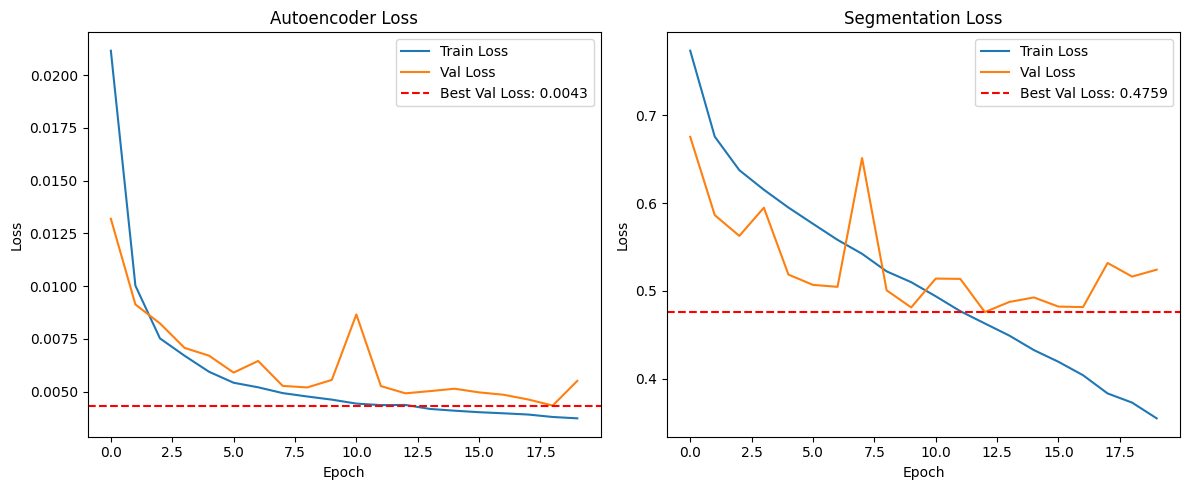

In [12]:
train_pipeline(
    train_loader, val_loader, test_loader,
    device, "runs/autoencoder/augmented_weighted_20epochs",
    autoencoder_epochs=20,
    segmentation_epochs=20
)